#IMPORT NECESSARY LIBRARIES

In [1]:
import os
import random
random.seed(42) # Set random seed for reproducibility
import time
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import RandomOverSampler
import imgaug.augmenters as iaa

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import models, transforms
from PIL import Image

time: 1.05 ms (started: 2024-08-03 09:59:12 +00:00)


##Define runtime

In [4]:
!pip install ipython-autotime
%load_ext autotime

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
time: 252 µs (started: 2024-08-03 09:41:30 +00:00)


#DATA PREPARATION

##Get Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/MASTER 1/Internship/ICT Lab/WORKSPACE/data/ISIC_2019/'

training_input_zip = data_dir + '/ISIC_2019_Training_Input.zip'
test_input_zip = data_dir + '/ISIC_2019_Test_Input.zip'

training_Metadata = data_dir + '/ISIC_2019_Training_Metadata.csv'
training_GroundTruth =  data_dir + '/ISIC_2019_Training_GroundTruth.csv'
test_Metadata = data_dir + '/ISIC_2019_Test_Metadata.csv'

# !unzip "$training_input_zip"
# !unzip "$test_input_zip"

training_input_dir = data_dir + '/ISIC_2019_Training_Input'
test_input_dir = data_dir + '/ISIC_2019_Test_Input'

Mounted at /content/drive
time: 1min 21s (started: 2024-08-03 09:41:30 +00:00)


##Import data

###Meta-data

In [6]:
train_metadata=pd.read_csv(training_Metadata)
train_metadata

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male
...,...,...,...,...,...
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female


time: 2.49 s (started: 2024-08-03 09:42:51 +00:00)


In [7]:
train_groundtruth=pd.read_csv(training_GroundTruth)
# # Drop the 'UNK' column
# train_groundtruth = train_groundtruth.drop(columns=['UNK'])
train_groundtruth

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 547 ms (started: 2024-08-03 09:42:54 +00:00)


In [8]:
test_metadata=pd.read_csv(test_Metadata)
test_metadata

,image,age_approx,anatom_site_general,sex
0,ISIC_0034321,60.0,NaN,female
1,ISIC_0034322,70.0,anterior torso,male
2,ISIC_0034323,70.0,lower extremity,male
3,ISIC_0034324,70.0,lower extremity,male
4,ISIC_0034325,30.0,upper extremity,female
...,...,...,...,...
8233,ISIC_0073236,75.0,anterior torso,male
8234,ISIC_0073243,65.0,lower extremity,male
8235,ISIC_0073250,30.0,anterior torso,female
8236,ISIC_0073252,85.0,head/neck,female


time: 525 ms (started: 2024-08-03 09:42:54 +00:00)


###Meta-data information

In [9]:
train_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB
time: 30.8 ms (started: 2024-08-03 09:42:55 +00:00)


In [10]:
train_groundtruth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   25331 non-null  object 
 1   MEL     25331 non-null  float64
 2   NV      25331 non-null  float64
 3   BCC     25331 non-null  float64
 4   AK      25331 non-null  float64
 5   BKL     25331 non-null  float64
 6   DF      25331 non-null  float64
 7   VASC    25331 non-null  float64
 8   SCC     25331 non-null  float64
 9   UNK     25331 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.9+ MB
time: 7.81 ms (started: 2024-08-03 09:42:55 +00:00)


In [11]:
test_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8238 entries, 0 to 8237
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                8238 non-null   object 
 1   age_approx           7912 non-null   float64
 2   anatom_site_general  7583 non-null   object 
 3   sex                  7899 non-null   object 
dtypes: float64(1), object(3)
memory usage: 257.6+ KB
time: 10.6 ms (started: 2024-08-03 09:42:55 +00:00)


In [12]:
def print_unique_counts(df, df_name):
    print(f"\n{'-'*40}")
    print(f"{df_name.upper()}")
    print(f"{'-'*40}")

    unique_counts = df.nunique()
    print("\nUnique entries in each column:")
    for col in unique_counts.index:
        print(f"- {col}: {unique_counts[col]}")

# Now use the function for each dataframe
print_unique_counts(train_metadata, 'Train Metadata')
print_unique_counts(train_groundtruth, 'Train Groundtruth')
print_unique_counts(test_metadata, 'Test Metadata')



----------------------------------------
TRAIN METADATA
----------------------------------------

Unique entries in each column:
- image: 25331
- age_approx: 18
- anatom_site_general: 8
- lesion_id: 11847
- sex: 2

----------------------------------------
TRAIN GROUNDTRUTH
----------------------------------------

Unique entries in each column:
- image: 25331
- MEL: 2
- NV: 2
- BCC: 2
- AK: 2
- BKL: 2
- DF: 2
- VASC: 2
- SCC: 2
- UNK: 1

----------------------------------------
TEST METADATA
----------------------------------------

Unique entries in each column:
- image: 8238
- age_approx: 18
- anatom_site_general: 7
- sex: 2
time: 46.2 ms (started: 2024-08-03 09:42:55 +00:00)


In [13]:
# train_metadata['anatom_site_general'].unique()

time: 229 µs (started: 2024-08-03 09:42:55 +00:00)


##Data Analysis

###Meta-data describe

In [14]:
def describe_and_check_nulls(df, df_name):
    print(f"\n{'-'*40}")
    print(f"{df_name.upper()}")
    print(f"{'-'*40}")

    print("\nDescription:")
    print(df.describe(include='all'))

    print("\nNull Values:")
    null_values = df.isnull().sum()
    print(null_values)

    print("\nPercentage of Null Values:")
    print(null_values / len(df) * 100)

# Now use the function for each dataframe
describe_and_check_nulls(train_metadata, 'Train Metadata')
describe_and_check_nulls(train_groundtruth, 'Train Groundtruth')
describe_and_check_nulls(test_metadata, 'Test Metadata')



----------------------------------------
TRAIN METADATA
----------------------------------------

Description:
               image    age_approx anatom_site_general    lesion_id    sex
count          25331  24894.000000               22700        23247  24947
unique         25331           NaN                   8        11847      2
top     ISIC_0073254           NaN      anterior torso  BCN_0001728   male
freq               1           NaN                6915           31  13286
mean             NaN     54.028481                 NaN          NaN    NaN
std              NaN     18.130971                 NaN          NaN    NaN
min              NaN      0.000000                 NaN          NaN    NaN
25%              NaN     40.000000                 NaN          NaN    NaN
50%              NaN     55.000000                 NaN          NaN    NaN
75%              NaN     70.000000                 NaN          NaN    NaN
max              NaN     85.000000                 NaN         

In [15]:
# train_metadata.describe(include='all')
# train_groundtruth.describe(include='all')
# test_metadata.describe(include='all')

# print("\ntrain_metadata")
# print(train_metadata.isnull().sum())
# print("\ntrain_groundtruth")
# print(train_groundtruth.isnull().sum())
# print("\ntest_metadata")
# print(test_metadata.isnull().sum())

time: 286 µs (started: 2024-08-03 09:42:55 +00:00)


###Plot data

In [16]:
# List of dataframes
dfs = [train_metadata, train_groundtruth, test_metadata]
df_names = ['train_metadata', 'train_groundtruth', 'test_metadata']

time: 308 µs (started: 2024-08-03 09:42:55 +00:00)


Plot missing values

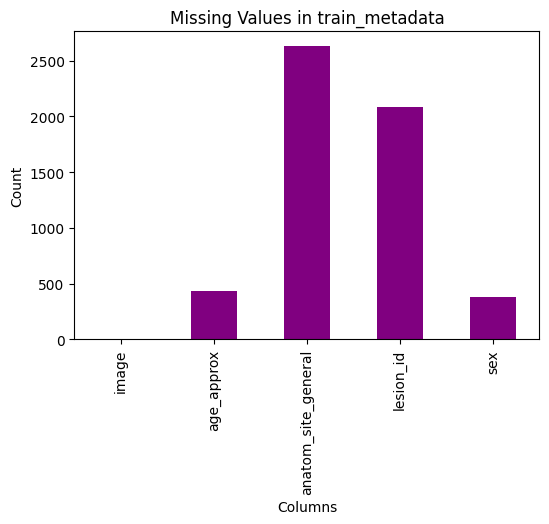

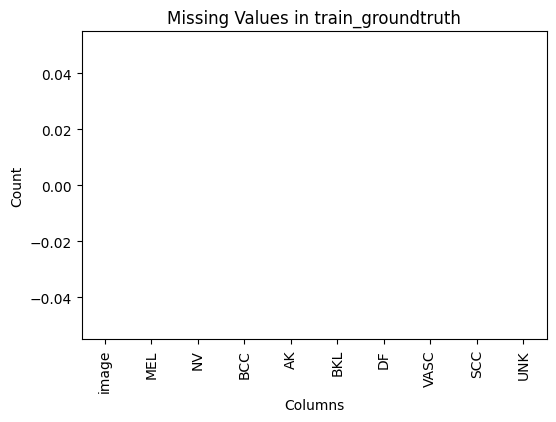

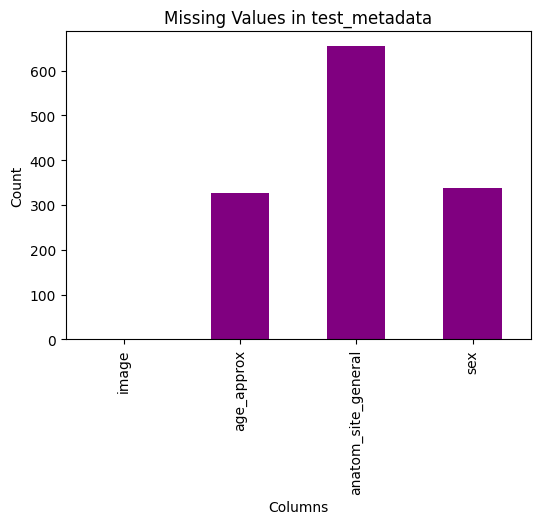

time: 756 ms (started: 2024-08-03 09:42:55 +00:00)


In [17]:
# Loop through dataframes
for i, df in enumerate(dfs):
    # Calculate missing values
    missing_values = df.isnull().sum()

    # Plot missing values
    plt.figure(figsize=(6, 4))
    missing_values.plot(kind='bar', color='purple')
    plt.title('Missing Values in ' + df_names[i])
    plt.ylabel('Count')
    plt.xlabel('Columns')
    plt.show()


In [18]:
# Describe each dataframe
def describe_columns(df, df_name):
    print(f"\n{'-'*40}")
    print(f"{df_name.upper()}")
    print(f"{'-'*40}")

    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    print("\nNumerical Columns:")
    for col in numerical_cols:
        print(f"- {col}")

    print("\nCategorical Columns:")
    for col in categorical_cols:
        print(f"- {col}")

# Describe each dataframe
describe_columns(train_metadata, 'Train Metadata')
describe_columns(train_groundtruth, 'Train Groundtruth')
describe_columns(test_metadata, 'Test Metadata')



----------------------------------------
TRAIN METADATA
----------------------------------------

Numerical Columns:
- age_approx

Categorical Columns:
- image
- anatom_site_general
- lesion_id
- sex

----------------------------------------
TRAIN GROUNDTRUTH
----------------------------------------

Numerical Columns:
- MEL
- NV
- BCC
- AK
- BKL
- DF
- VASC
- SCC
- UNK

Categorical Columns:
- image

----------------------------------------
TEST METADATA
----------------------------------------

Numerical Columns:
- age_approx

Categorical Columns:
- image
- anatom_site_general
- sex
time: 18.6 ms (started: 2024-08-03 09:42:56 +00:00)


In [19]:
# Define categorical and numerical columns
categorical_columns = ['lesion_id', 'image', 'anatom_site_general', 'sex']
numerical_columns = ['age_approx']


time: 544 µs (started: 2024-08-03 09:42:56 +00:00)


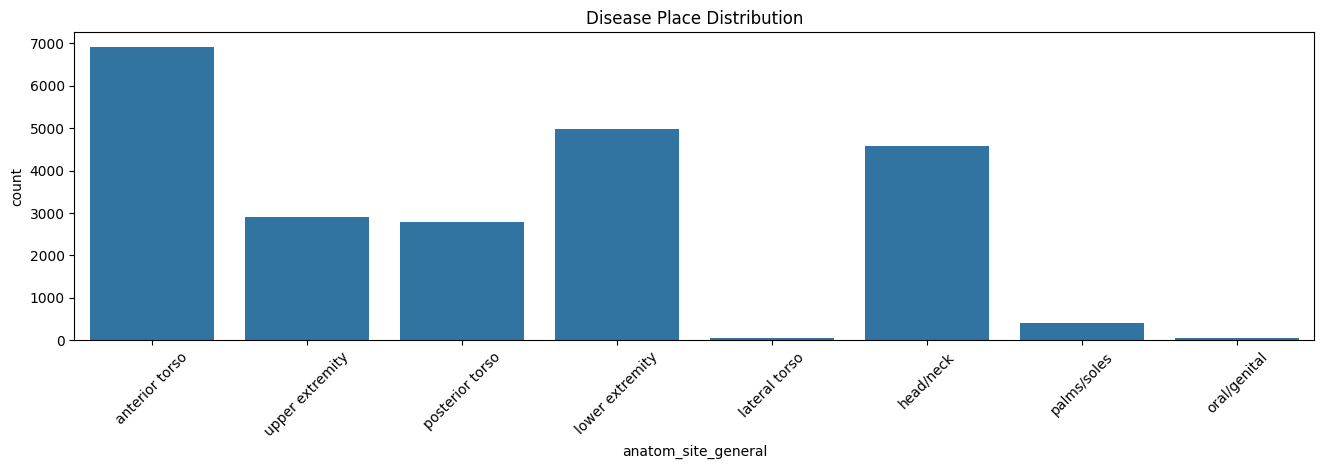

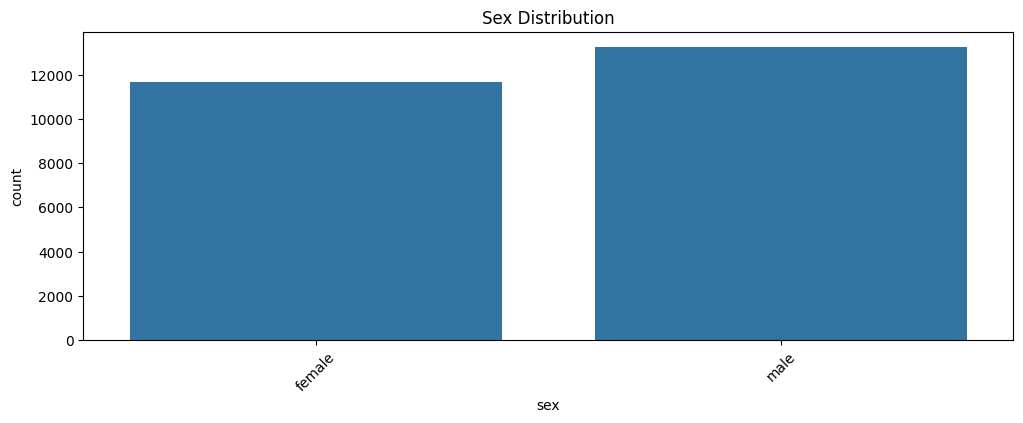

time: 651 ms (started: 2024-08-03 09:42:56 +00:00)


In [20]:
# Distribution of value count for Location of disease
for column in categorical_columns:
    train_metadata['anatom_site_general'].value_counts()

train_metadata['anatom_site_general'].value_counts()

plt.figure(figsize=(16, 4))
sns.countplot(data=train_metadata, x='anatom_site_general')
plt.title('Disease Place Distribution')
plt.xticks(rotation=45)
plt.show()

# Distribution of value count for Sex in the dataset
for column in categorical_columns:
    train_metadata['sex'].value_counts()

train_metadata['sex'].value_counts()

plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='sex')
plt.title('Sex Distribution')
plt.xticks(rotation=45)
plt.show()

# # Distribution of value count for Type of disease
# for column in categorical_columns:
#     train_metadata['lesion_id'].value_counts()

# train_metadata['lesion_id'].value_counts()

# plt.figure(figsize=(12, 4))
# sns.countplot(data=train_metadata, x='lesion_id')
# plt.title('Lesion ID Distribution')
# plt.xticks(rotation=45)
# plt.show()

# # Distribution of value count for Type of disease
# for column in categorical_columns:
#     train_metadata['image'].value_counts()

# train_metadata['image'].value_counts()

# plt.figure(figsize=(12, 4))
# sns.countplot(data=train_metadata, x='image')
# plt.title('Image Name Distribution')
# plt.xticks(rotation=45)
# plt.show()

plot Groundtruth


<ipython-input-21-57af30f33fcc>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=disease_type_counts_df, x='Disease Type', y='Count', palette='viridis')


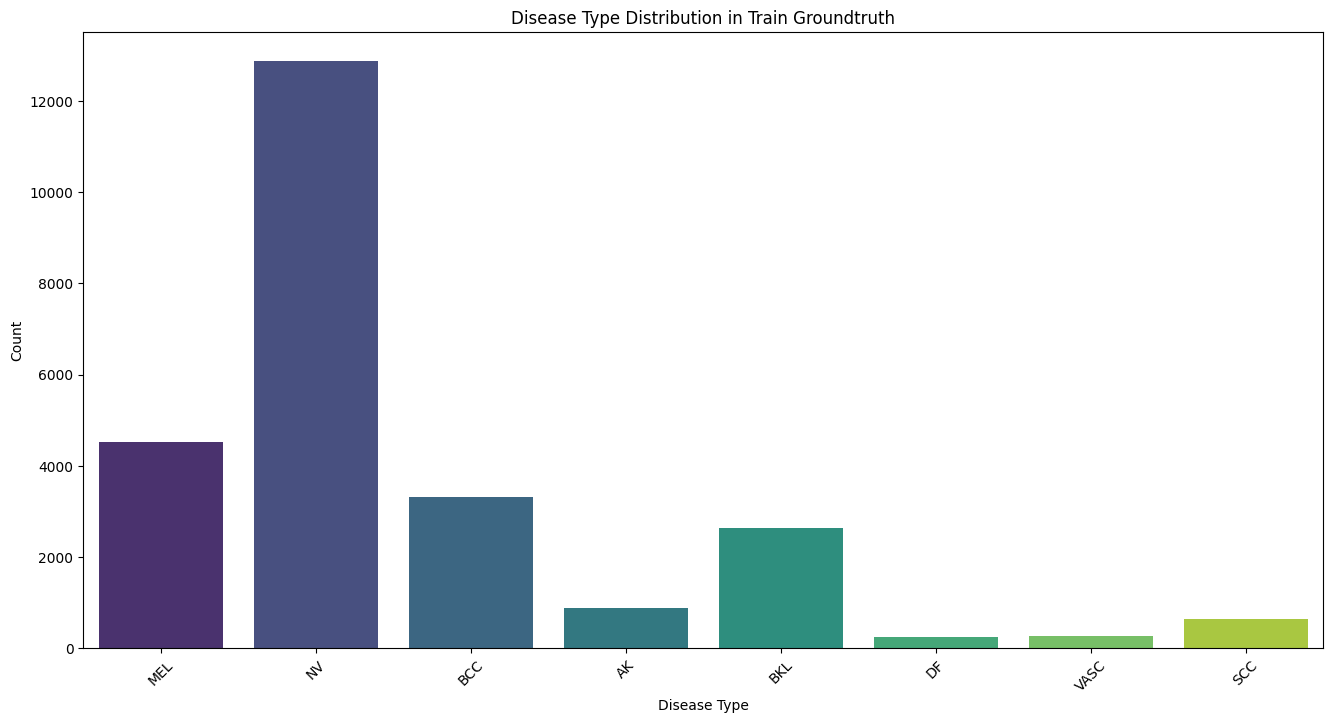

time: 364 ms (started: 2024-08-03 09:42:57 +00:00)


In [21]:
# Define columns to plot (excluding 'image' and 'UNK')
disease_type = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

# Sum up the counts of each class
disease_type_counts = train_groundtruth[disease_type].sum()

# Convert to DataFrame for easier plotting
disease_type_counts_df = pd.DataFrame(disease_type_counts).reset_index()
disease_type_counts_df.columns = ['Disease Type', 'Count']

# Plot
plt.figure(figsize=(16, 8))
sns.barplot(data=disease_type_counts_df, x='Disease Type', y='Count', palette='viridis')
plt.title('Disease Type Distribution in Train Groundtruth')
plt.xlabel('Disease Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


###Data Analysis for Relationship among variables

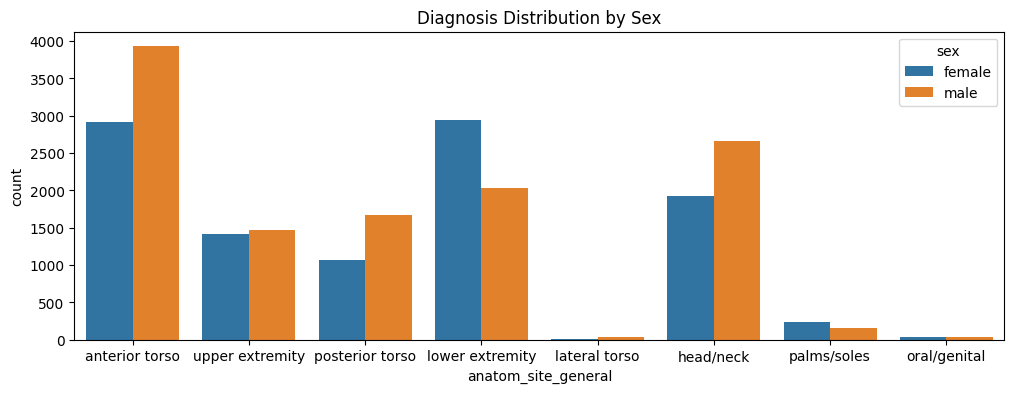

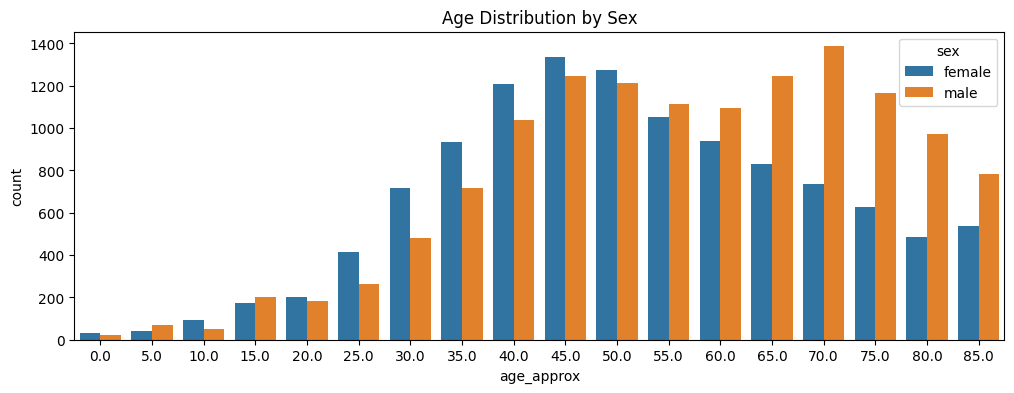

time: 1.4 s (started: 2024-08-03 09:42:57 +00:00)


In [22]:
# Visualizing relationships between anatom_site_general and sex
plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='anatom_site_general', hue='sex')
plt.title('Diagnosis Distribution by Sex')
plt.show()

# Visualizing relationships between age_approx and sex
plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='age_approx', hue='sex')
plt.title('Age Distribution by Sex')
plt.show()

In [23]:
# Merge the metadata and groundtruth dataframes on the 'image' column
combined_df = pd.merge(train_metadata, train_groundtruth, on='image')

# Melt the dataframe to have disease types as a single column
melted_df = pd.melt(combined_df, id_vars=['image', 'sex', 'age_approx', 'anatom_site_general'], value_vars=disease_type)

# Filter out rows where value is 0 (i.e., the disease type is not present)
filtered_df = melted_df[melted_df['value'] == 1]

time: 126 ms (started: 2024-08-03 09:42:59 +00:00)


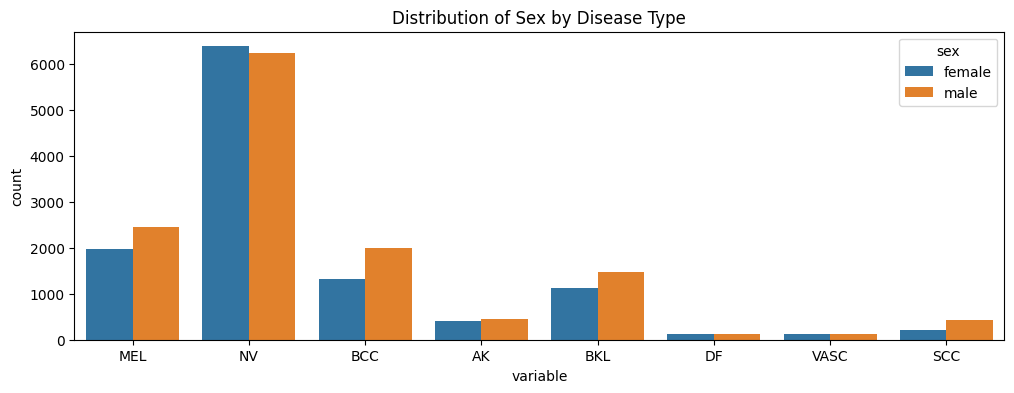

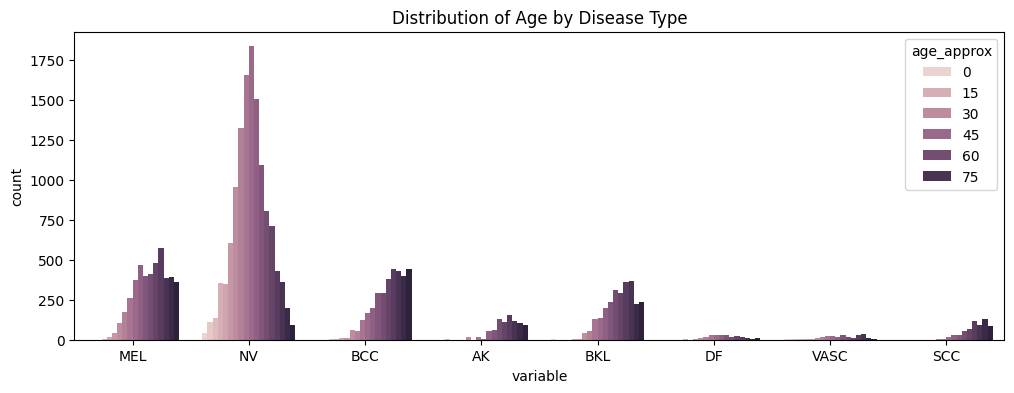

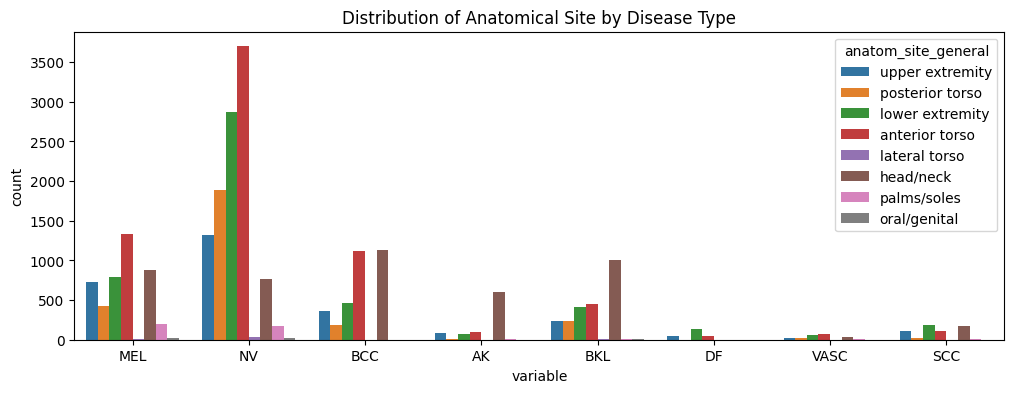

time: 2.72 s (started: 2024-08-03 09:42:59 +00:00)


In [24]:
# Plot the distribution of 'sex' by disease type
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='variable', hue='sex')
plt.title('Distribution of Sex by Disease Type')
plt.show()

# Plot the distribution of 'age_approx' by disease type
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='variable', hue='age_approx')
plt.title('Distribution of Age by Disease Type')
plt.show()

# Plot the distribution of 'anatom_site_general' by disease type
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='variable', hue='anatom_site_general')
plt.title('Distribution of Anatomical Site by Disease Type')
plt.show()

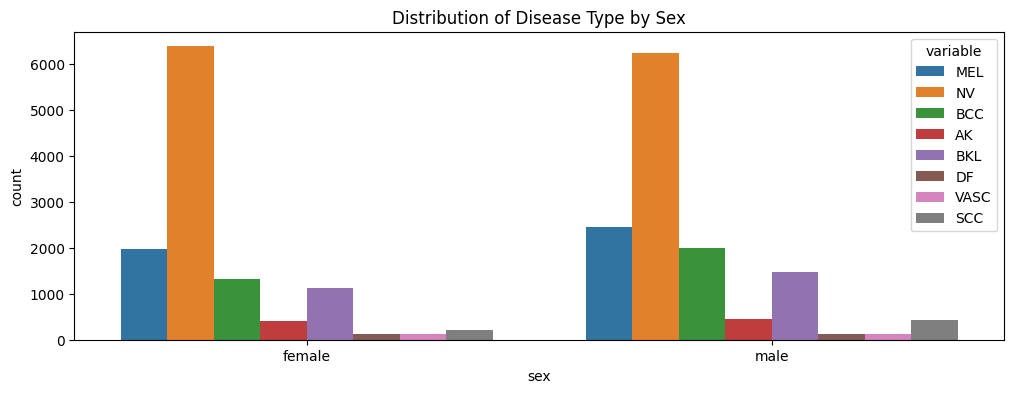

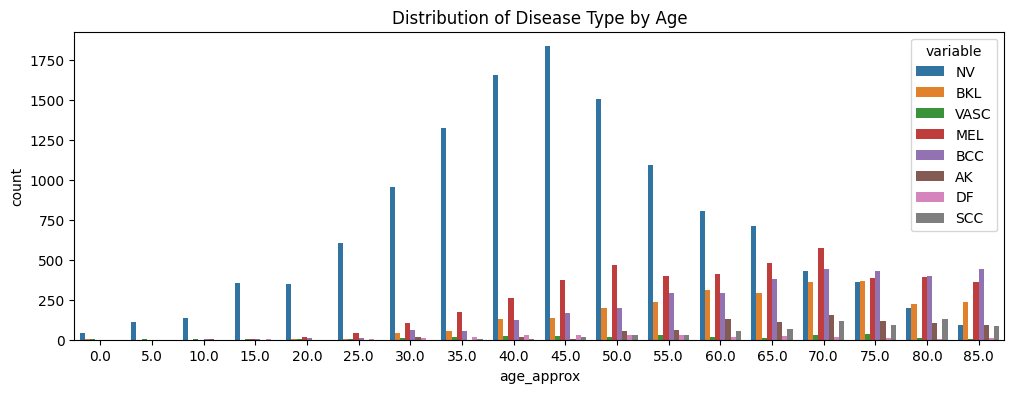

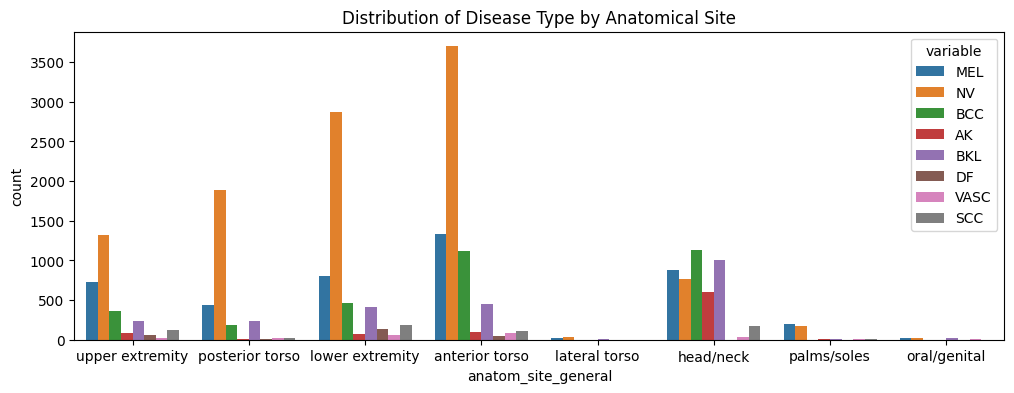

time: 1.9 s (started: 2024-08-03 09:43:01 +00:00)


In [25]:
# Plot the distribution of disease type by 'sex'
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='sex', hue='variable')
plt.title('Distribution of Disease Type by Sex')
plt.show()

# Plot the distribution of disease type by 'age_approx'
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='age_approx', hue='variable')
plt.title('Distribution of Disease Type by Age')
plt.show()

# Plot the distribution of disease type by 'anatom_site_general'
plt.figure(figsize=(12, 4))
sns.countplot(data=filtered_df, x='anatom_site_general', hue='variable')
plt.title('Distribution of Disease Type by Anatomical Site')
plt.show()


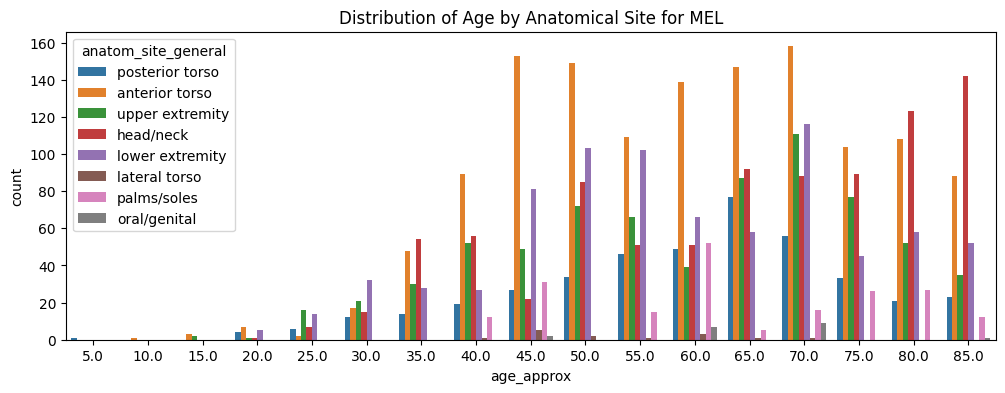

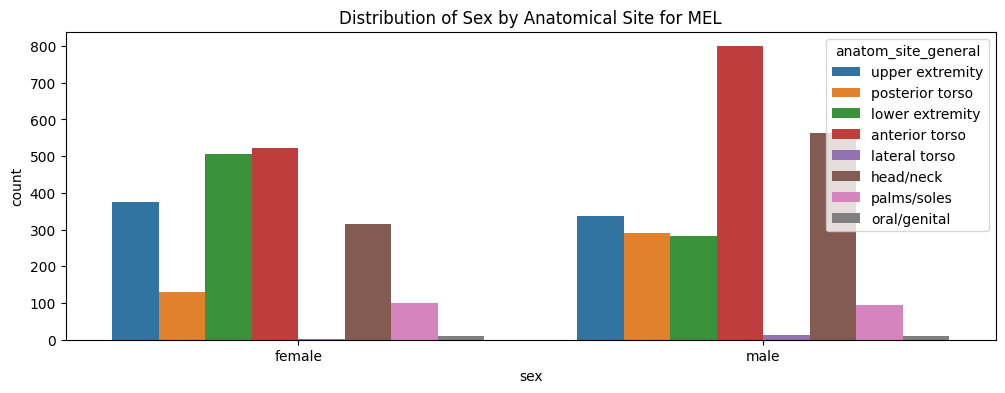

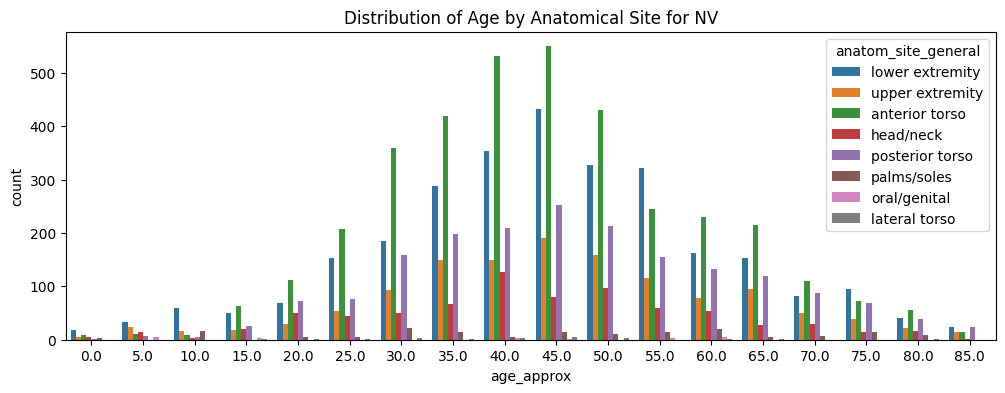

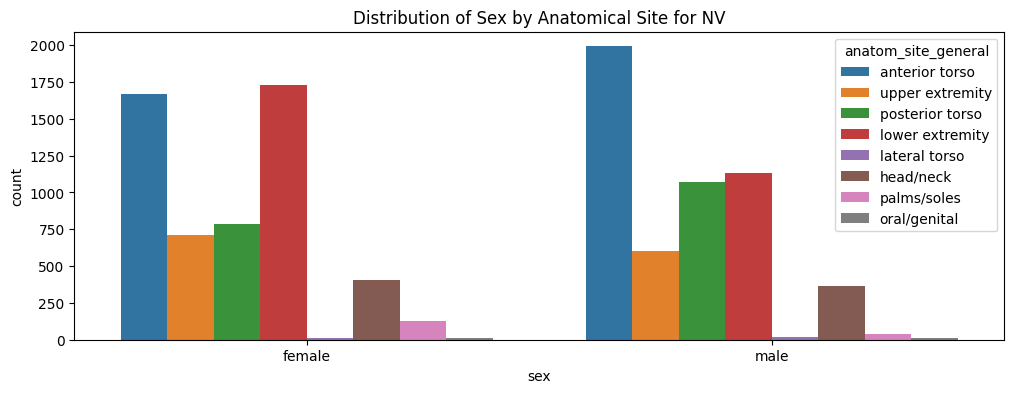

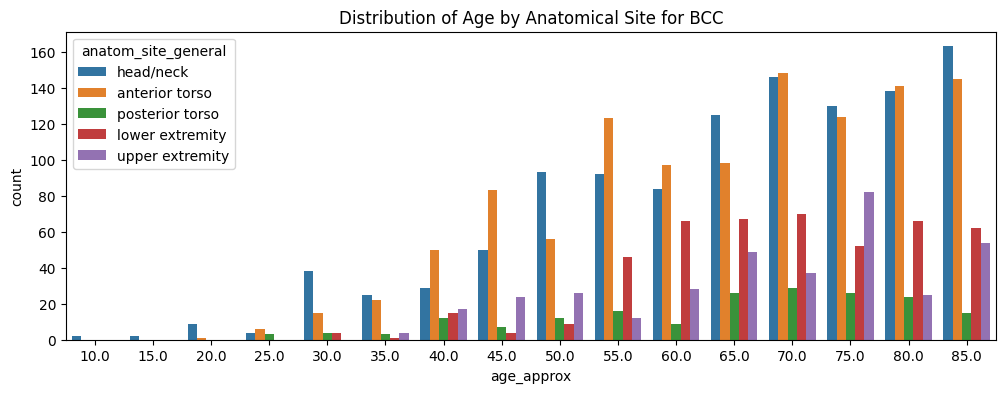

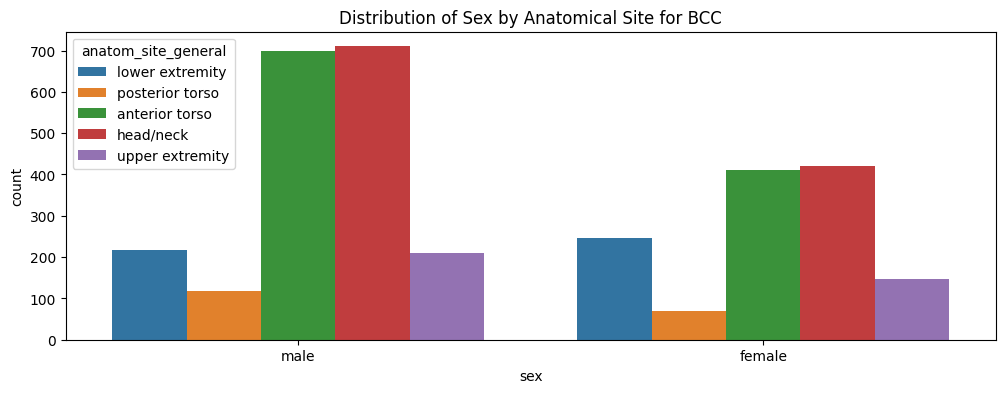

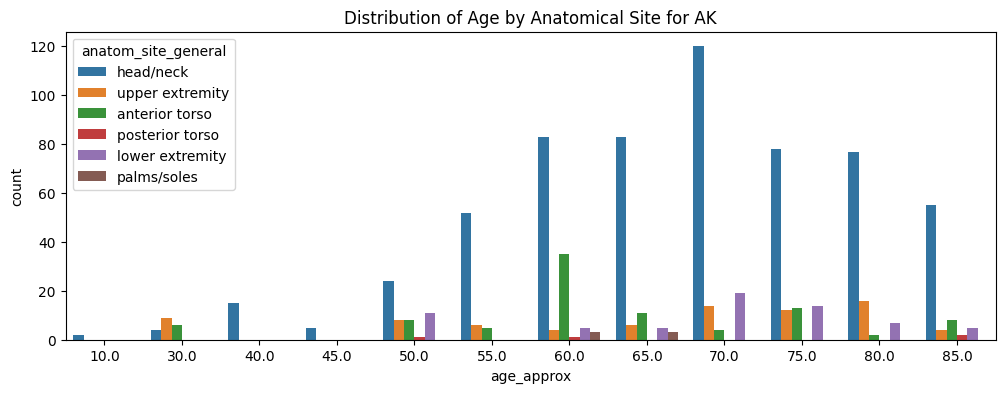

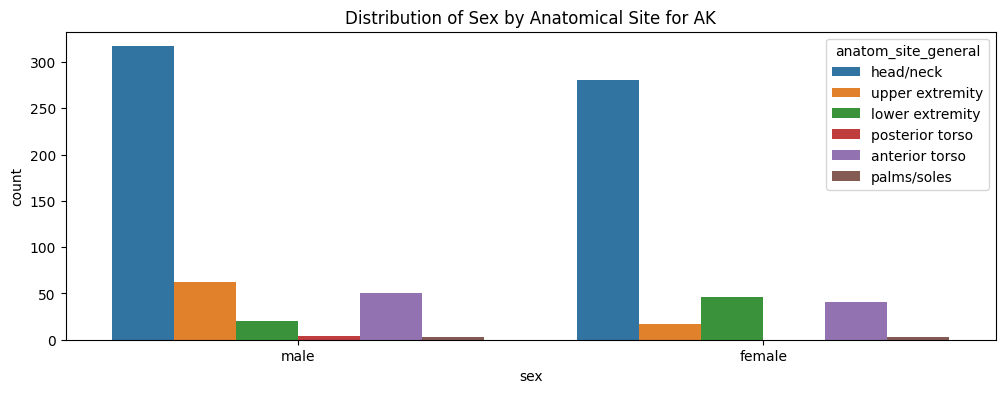

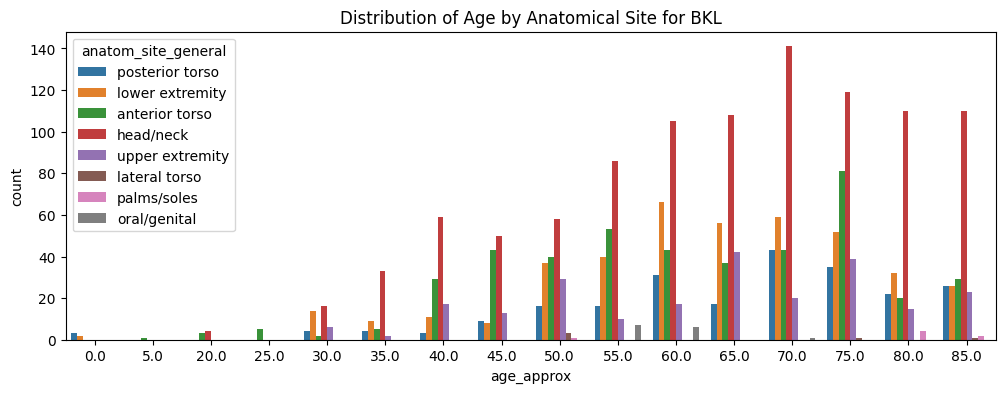

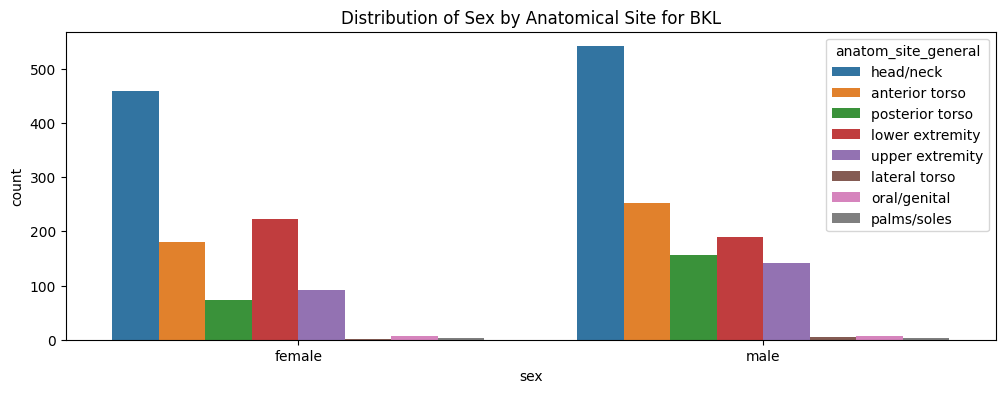

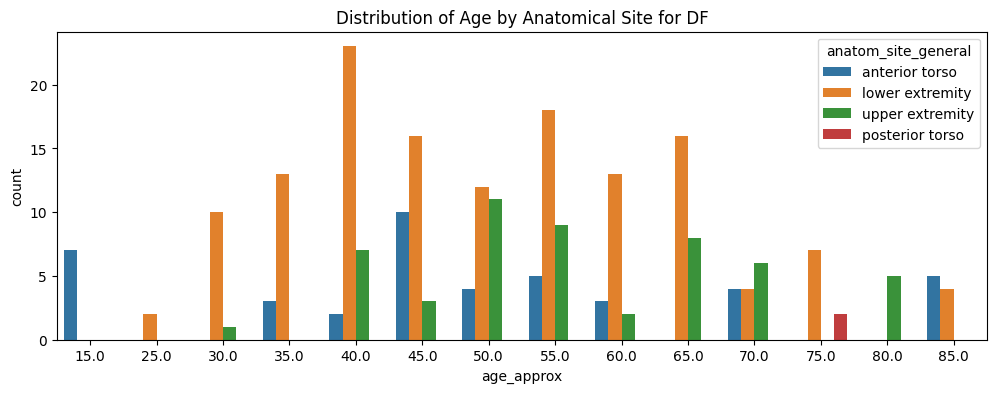

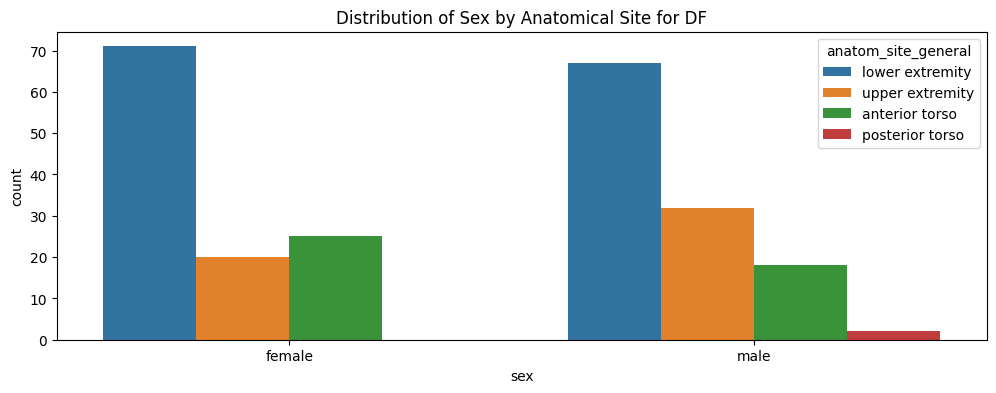

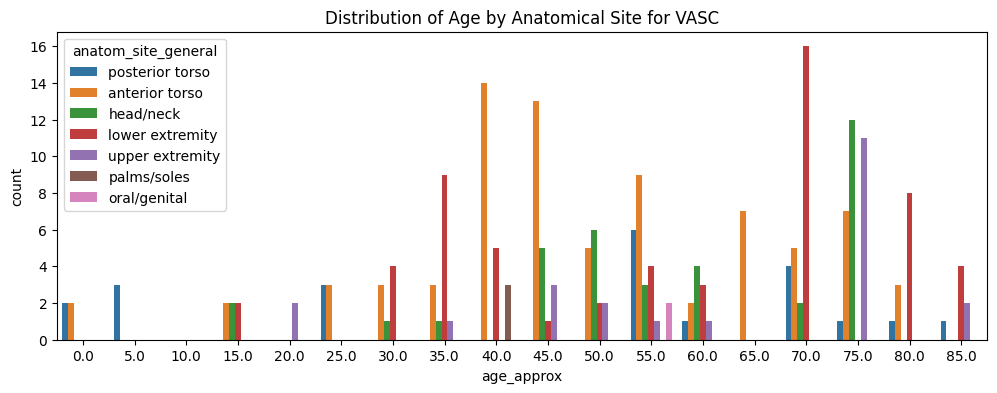

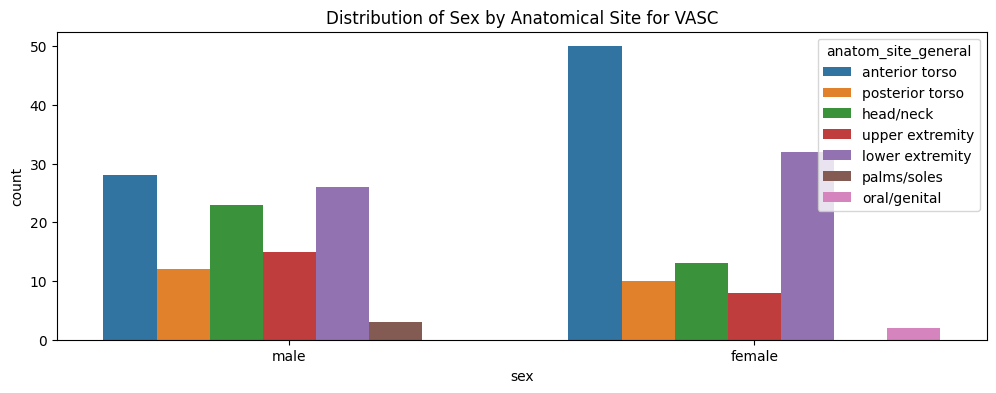

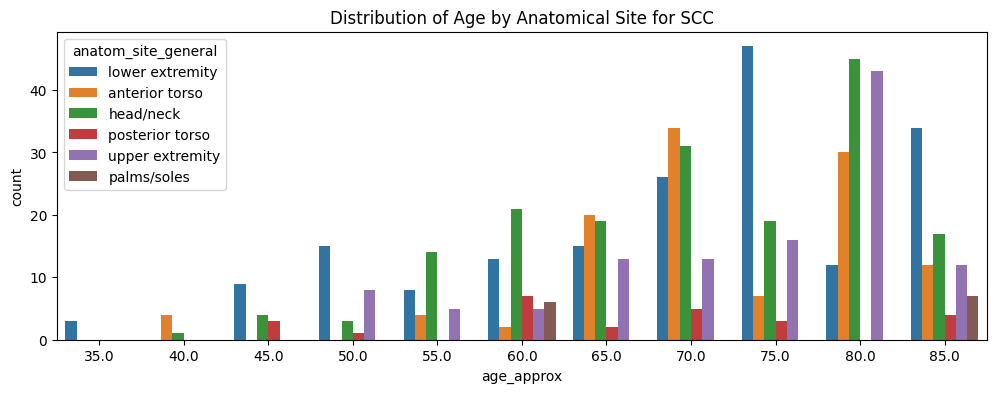

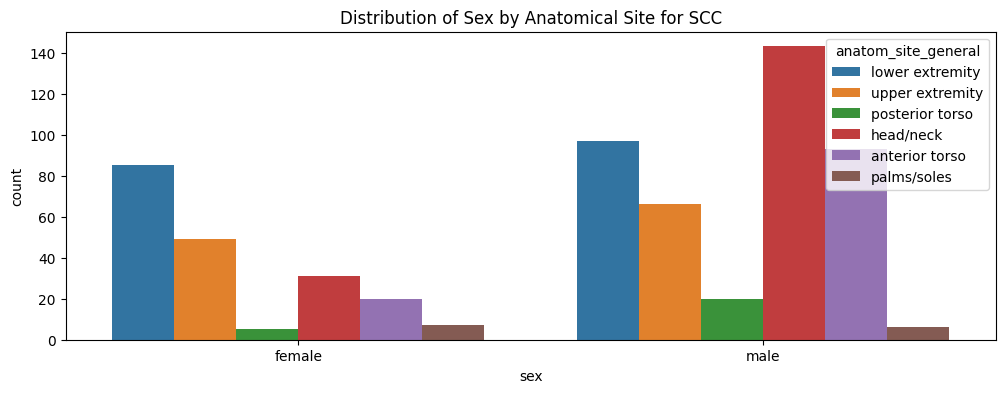

time: 6.38 s (started: 2024-08-03 09:43:03 +00:00)


In [26]:
# Loop through each disease type
for disease in disease_type:
    # Create a subset of the dataframe for the current disease type
    subset_df = combined_df[combined_df[disease] == 1]

    # Plot the distribution of 'age_approx' by 'anatom_site_general'
    plt.figure(figsize=(12, 4))
    sns.countplot(data=subset_df, x='age_approx', hue='anatom_site_general')
    plt.title(f'Distribution of Age by Anatomical Site for {disease}')
    plt.show()

    # Plot the distribution of 'sex' by 'anatom_site_general'
    plt.figure(figsize=(12, 4))
    sns.countplot(data=subset_df, x='sex', hue='anatom_site_general')
    plt.title(f'Distribution of Sex by Anatomical Site for {disease}')
    plt.show()


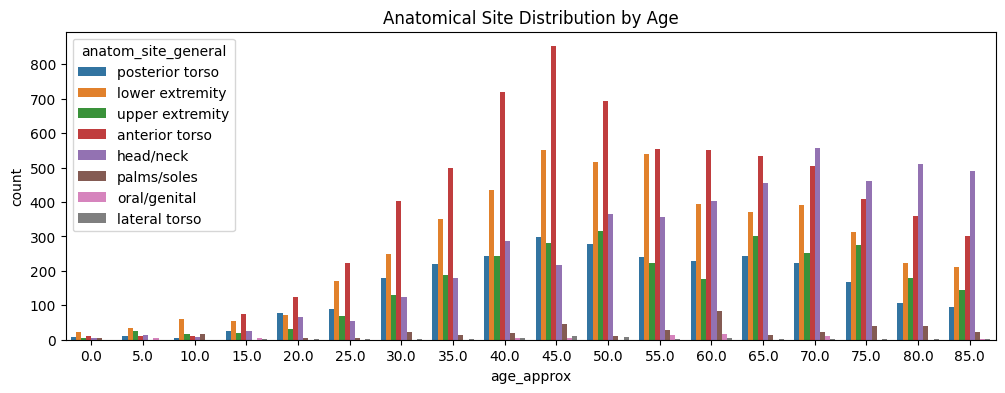

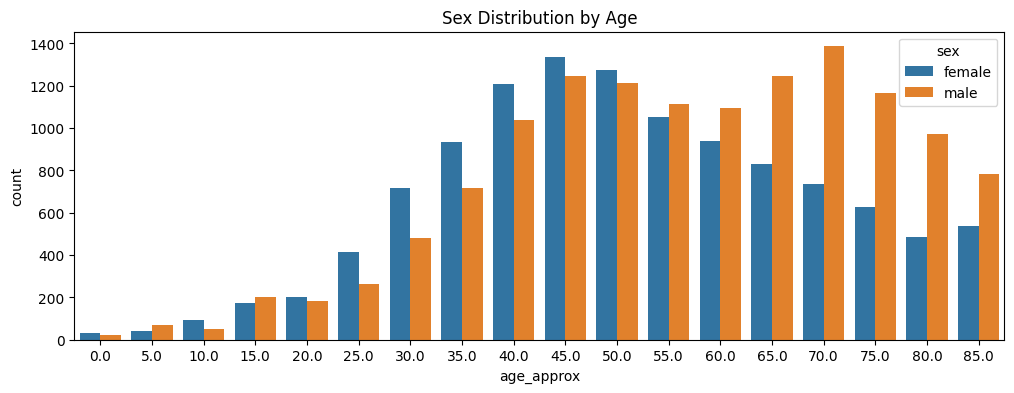

time: 1.1 s (started: 2024-08-03 09:43:10 +00:00)


In [27]:
# Visualizing relationships between categorical columns
plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='age_approx', hue='anatom_site_general')
plt.title('Anatomical Site Distribution by Age')
plt.show()

# Visualizing relationships between categorical columns
plt.figure(figsize=(12, 4))
sns.countplot(data=train_metadata, x='age_approx', hue='sex')
plt.title('Sex Distribution by Age')
plt.show()

##DATA PREPROCESSING

In [28]:
train_metadata.info()
print()
train_metadata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
dtypes: float64(1), object(4)
memory usage: 989.6+ KB



,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


time: 51.4 ms (started: 2024-08-03 09:43:11 +00:00)


###Data cleansing

identifying and correcting errors or inconsistencies in the data.

In [29]:
print(train_metadata.columns)

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex'], dtype='object')
time: 569 µs (started: 2024-08-03 09:43:11 +00:00)


In [30]:
# Convert the train_groundtruth DataFrame from wide format to long format
melted_groundtruth = train_groundtruth.melt(id_vars='image', var_name='disease_type', value_name='presence')


# THIS LINE REMOVE UNK COLUMN
# Filter out rows where presence is 0 (i.e., the disease type is not present)
filtered_groundtruth = melted_groundtruth[melted_groundtruth['presence'] == 1]

# Merge the train_metadata and filtered_groundtruth DataFrames on the 'image' column
combined_train_df = pd.merge(train_metadata, filtered_groundtruth, on='image')

print(combined_train_df.columns)

Index(['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex',
       'disease_type', 'presence'],
      dtype='object')
time: 36.1 ms (started: 2024-08-03 09:43:11 +00:00)


In [31]:
# Removing duplicate rows
train_metadata_pp = combined_train_df.drop_duplicates()

# Removing rows with missing values
train_metadata_pp = train_metadata_pp.dropna()

# Replace missing values in 'age' column with median age
median_age = train_metadata_pp['age_approx'].median()
train_metadata_pp['age_approx'] = train_metadata_pp['age_approx'].fillna(median_age)

# Fixing column names
train_metadata_pp = train_metadata_pp.rename(columns={
    'image': 'Image_Id',
    'age_approx': 'Age',
    'anatom_site_general': 'Region_Of_Disease',
    'lesion_id': 'Lesion_Id',
    'sex': 'Sex',
    'disease_type': 'Disease_Type',
    'presence': 'Presence'
})

# Define the mapping of current values to new values
diagnosis_mapping = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic Nevi',
    'BCC': 'Basal Cell Carcinoma',
    'AK': 'Actinic Keratoses',
    'BKL': 'Benign Keratosis-Like Lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular Lesions',
    'SCC': 'Squamous Cell Carcinoma',
    'UNK': 'Unknown'
}

# Convert the Age column to integers
train_metadata_pp['Age'] = train_metadata_pp['Age'].astype(int)

# Create a new column with the updated diagnosis names
train_metadata_pp['Diagnosis'] = train_metadata_pp['Disease_Type'].map(diagnosis_mapping)

time: 37.2 ms (started: 2024-08-03 09:43:11 +00:00)


In [32]:
for col in train_metadata_pp.columns:
  print(f'{col}: {train_metadata_pp[col].unique()}\n')

Image_Id: ['ISIC_0012653_downsampled' 'ISIC_0012654_downsampled'
 'ISIC_0012655_downsampled' ... 'ISIC_0073249' 'ISIC_0073251'
 'ISIC_0073254']

Age: [50 30 35 45 20 40 75 25 70 60 55 65 80 85 15 10  5  0]

Region_Of_Disease: ['posterior torso' 'lower extremity' 'upper extremity' 'head/neck'
 'anterior torso' 'lateral torso' 'palms/soles' 'oral/genital']

Lesion_Id: ['MSK4_0011169' 'MSK4_0011170' 'MSK4_0011171' ... 'BCN_0002147'
 'BCN_0001946' 'BCN_0001014']

Sex: ['female' 'male']

Disease_Type: ['NV' 'BKL' 'MEL' 'DF' 'SCC' 'BCC' 'VASC' 'AK']

Presence: [1.]

Diagnosis: ['Melanocytic Nevi' 'Benign Keratosis-Like Lesions' 'Melanoma'
 'Dermatofibroma' 'Squamous Cell Carcinoma' 'Basal Cell Carcinoma'
 'Vascular Lesions' 'Actinic Keratoses']

time: 16.4 ms (started: 2024-08-03 09:43:11 +00:00)


In [33]:
train_metadata_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21311 entries, 1459 to 25330
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           21311 non-null  object 
 1   Age                21311 non-null  int64  
 2   Region_Of_Disease  21311 non-null  object 
 3   Lesion_Id          21311 non-null  object 
 4   Sex                21311 non-null  object 
 5   Disease_Type       21311 non-null  object 
 6   Presence           21311 non-null  float64
 7   Diagnosis          21311 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.5+ MB
time: 12.4 ms (started: 2024-08-03 09:43:11 +00:00)


In [34]:
train_metadata_pp

,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Diagnosis
1459,ISIC_0012653_downsampled,50,posterior torso,MSK4_0011169,female,NV,1.0,Melanocytic Nevi
1460,ISIC_0012654_downsampled,30,lower extremity,MSK4_0011170,female,NV,1.0,Melanocytic Nevi
1461,ISIC_0012655_downsampled,35,upper extremity,MSK4_0011171,female,NV,1.0,Melanocytic Nevi
1462,ISIC_0012656_downsampled,45,posterior torso,MSK4_0011172,male,NV,1.0,Melanocytic Nevi
1463,ISIC_0012657_downsampled,20,upper extremity,MSK4_0011173,female,NV,1.0,Melanocytic Nevi
...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85,head/neck,BCN_0003925,female,BCC,1.0,Basal Cell Carcinoma
25327,ISIC_0073248,65,anterior torso,BCN_0001819,male,BKL,1.0,Benign Keratosis-Like Lesions
25328,ISIC_0073249,70,lower extremity,BCN_0001085,male,MEL,1.0,Melanoma
25329,ISIC_0073251,55,palms/soles,BCN_0002083,female,NV,1.0,Melanocytic Nevi


time: 85.1 ms (started: 2024-08-03 09:43:11 +00:00)


###Get images data

finish preprocessing

In [36]:
# Map image paths
train_image_dir = training_input_dir
image_paths = [os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir)]
image_path_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in image_paths}
train_metadata_pp['Image_path'] = train_metadata_pp['Image_Id'].map(image_path_dict)

train_metadata_pp

,Image_Id,Age,Region_Of_Disease,Lesion_Id,Sex,Disease_Type,Presence,Diagnosis,Image_path
1459,ISIC_0012653_downsampled,50,posterior torso,MSK4_0011169,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
1460,ISIC_0012654_downsampled,30,lower extremity,MSK4_0011170,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
1461,ISIC_0012655_downsampled,35,upper extremity,MSK4_0011171,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
1462,ISIC_0012656_downsampled,45,posterior torso,MSK4_0011172,male,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
1463,ISIC_0012657_downsampled,20,upper extremity,MSK4_0011173,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...
...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,85,head/neck,BCN_0003925,female,BCC,1.0,Basal Cell Carcinoma,/content/drive/MyDrive/MASTER 1/Internship/ICT...
25327,ISIC_0073248,65,anterior torso,BCN_0001819,male,BKL,1.0,Benign Keratosis-Like Lesions,/content/drive/MyDrive/MASTER 1/Internship/ICT...
25328,ISIC_0073249,70,lower extremity,BCN_0001085,male,MEL,1.0,Melanoma,/content/drive/MyDrive/MASTER 1/Internship/ICT...
25329,ISIC_0073251,55,palms/soles,BCN_0002083,female,NV,1.0,Melanocytic Nevi,/content/drive/MyDrive/MASTER 1/Internship/ICT...


time: 7.88 s (started: 2024-08-03 09:50:12 +00:00)


In [37]:
train_metadata_pp = train_metadata_pp.sample(n=5000, random_state=42)
train_metadata_pp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 19360 to 7033
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Image_Id           5000 non-null   object 
 1   Age                5000 non-null   int64  
 2   Region_Of_Disease  5000 non-null   object 
 3   Lesion_Id          5000 non-null   object 
 4   Sex                5000 non-null   object 
 5   Disease_Type       5000 non-null   object 
 6   Presence           5000 non-null   float64
 7   Diagnosis          5000 non-null   object 
 8   Image_path         5000 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 390.6+ KB
time: 14.9 ms (started: 2024-08-03 09:50:20 +00:00)


###Correctting image paths

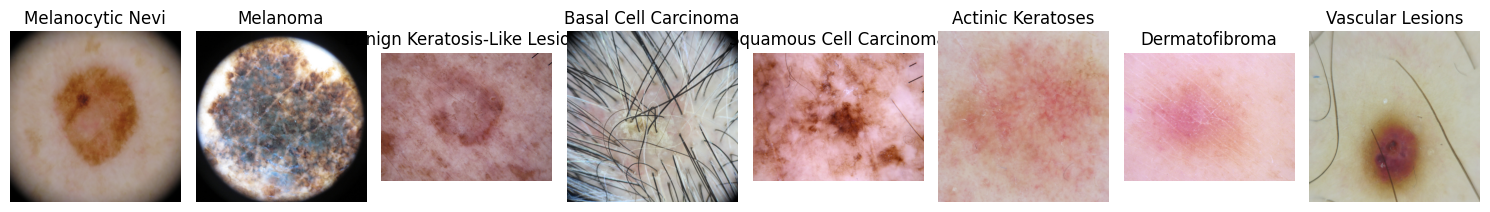

time: 9.57 s (started: 2024-08-03 09:50:20 +00:00)


In [38]:
# Ensure that the image paths are correct and accessible
for i in range(len(train_metadata_pp)):
    if not os.path.isfile(train_metadata_pp['Image_path'].iloc[i]):
        raise FileNotFoundError(f"Image file not found: {train_metadata_pp['Image_path'].iloc[i]}")

# Get one image per class
class_images = train_metadata_pp.drop_duplicates(subset='Diagnosis')

# Plot one image per class
def plot_class_images(class_images):
    plt.figure(figsize=(15, 5))
    num_classes = len(class_images)
    for i in range(num_classes):
        plt.subplot(1, num_classes, i + 1)
        img = plt.imread(class_images['Image_path'].iloc[i])
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_images['Diagnosis'].iloc[i], fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function to plot images
plot_class_images(class_images)

#MODEL IMPLEMENTATION

##Functionalities

###Label Encoder

In [39]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder and transform 'Region_Of_Disease' column
train_metadata_pp['Diagnosis_Label'] = label_encoder.fit_transform(train_metadata_pp['Diagnosis'])

# Display the mapping between original labels and encoded labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Encoding Mapping:")
print(label_mapping)

Label Encoding Mapping:
{'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
time: 5.08 ms (started: 2024-08-03 09:50:35 +00:00)


###Augment and transfrom dataset

In [40]:
# Data augmentation and transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

time: 992 µs (started: 2024-08-03 09:50:36 +00:00)


###Split data

In [41]:
# Split the dataset into train and temp (80% train, 20% temp)
train_df, temp_df = train_test_split(train_metadata_pp, test_size=0.2, stratify=train_metadata_pp['Diagnosis_Label'], random_state=42)

# Split the temp dataset into validation and test (50% val, 50% test of the 20% temp)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Diagnosis_Label'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 4000
Validation set size: 500
Test set size: 500
time: 12.3 ms (started: 2024-08-03 09:50:36 +00:00)


###Balancing dataset

In [42]:
# Separate features and labels for balancing
X_train = train_df.drop(columns=['Diagnosis_Label'])
y_train = train_df['Diagnosis_Label']

# Apply RandomOverSampler only to the training set
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Combine resampled features and labels into a DataFrame
train_df_resampled = X_resampled.copy()
train_df_resampled['Diagnosis_Label'] = y_resampled

print(f"Resampled training set size: {len(train_df_resampled)}")

Resampled training set size: 14616
time: 29.7 ms (started: 2024-08-03 09:50:36 +00:00)


###Custom dataset class

In [43]:
#  make easily load and preprocess dataset -> compatible with PyTorch’s data loading utilities.
class LoadedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['Diagnosis_Label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets and dataloaders
train_dataset = LoadedDataset(train_df_resampled, transform=transform)
val_dataset = LoadedDataset(val_df, transform=transform)
test_dataset = LoadedDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Example of iterating through the dataloader and printing results
for images, labels in train_loader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    print(f"Labels: {labels}")

    print("Label Mapping:", label_mapping)
    print("Unique Labels in Dataset:", train_metadata_pp['Diagnosis_Label'].unique())

    break  # Print only the first batch

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch of images shape: torch.Size([32, 3, 224, 224])
Batch of labels shape: torch.Size([32])
Labels: tensor([3, 5, 0, 0, 4, 5, 4, 4, 2, 6, 4, 4, 7, 4, 0, 1, 0, 0, 2, 3, 0, 1, 3, 4,
        5, 4, 4, 6, 1, 0, 6, 2])
Label Mapping: {'Actinic Keratoses': 0, 'Basal Cell Carcinoma': 1, 'Benign Keratosis-Like Lesions': 2, 'Dermatofibroma': 3, 'Melanocytic Nevi': 4, 'Melanoma': 5, 'Squamous Cell Carcinoma': 6, 'Vascular Lesions': 7}
Unique Labels in Dataset: [4 5 2 1 6 0 3 7]
time: 37.7 s (started: 2024-08-03 09:50:36 +00:00)


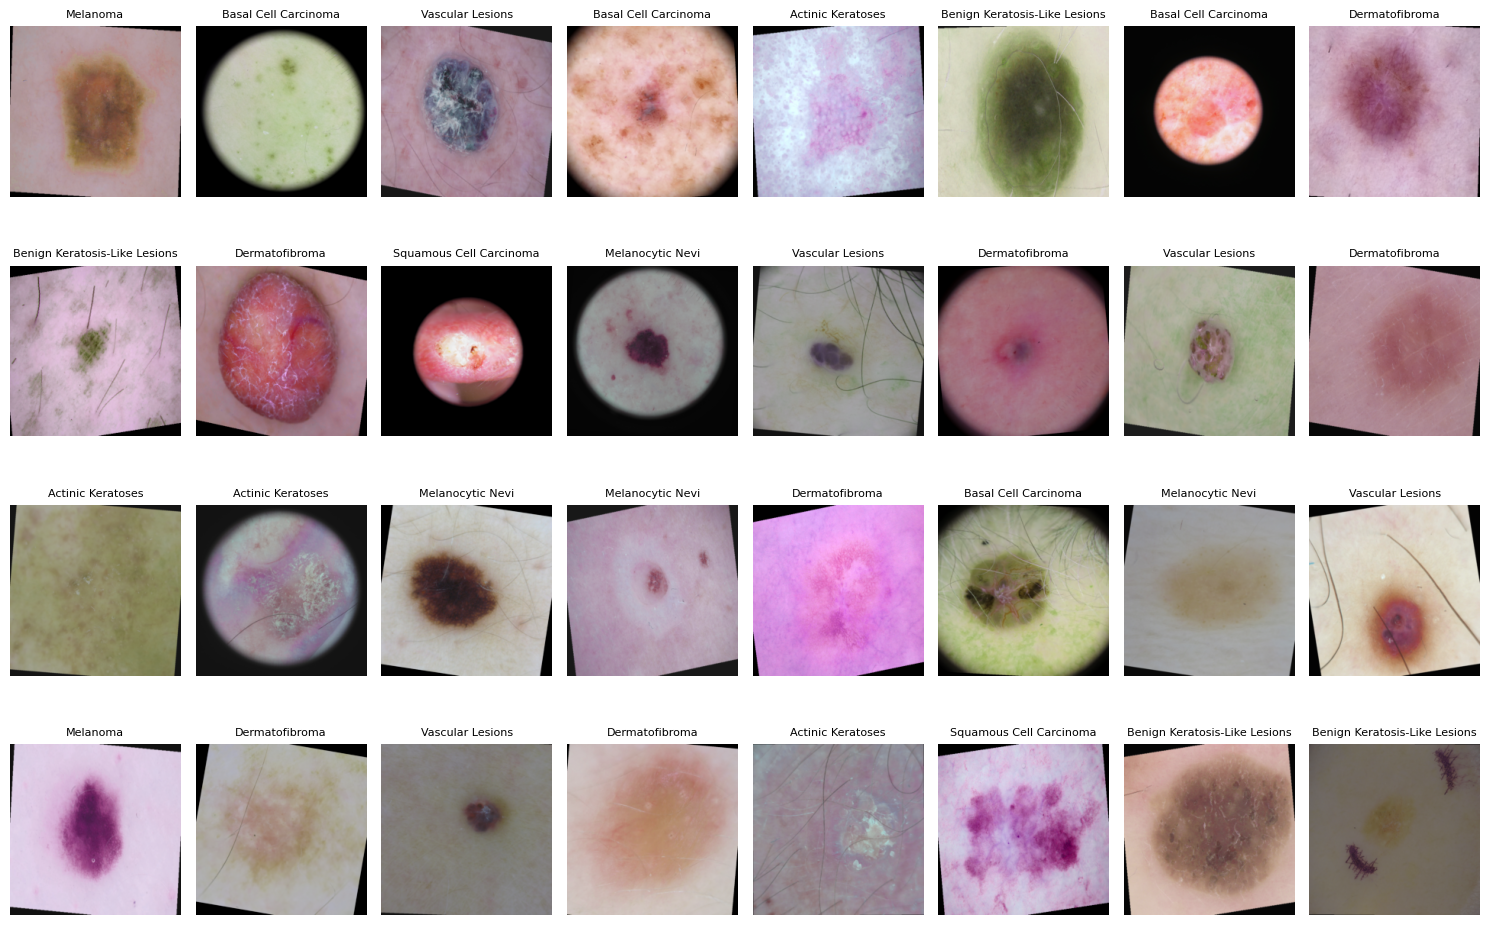

time: 37.7 s (started: 2024-08-03 09:51:14 +00:00)


In [44]:
# Function to plot a batch of images
def plot_batch_images(images, labels, label_mapping):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(4, 8, i + 1)

        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and rearrange dimensions
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize
        img = np.clip(img, 0, 1)  # Clip values to be in the range [0, 1]
        plt.imshow(img)
        plt.axis('off')

        label = labels[i].item()
        # label_name = label_mapping.get(label, "Unknown")  # Handle potential mismatches
        label_name = list(label_mapping.keys())[list(label_mapping.values()).index(label)]  # Get label name
        plt.title(label_name, fontsize=8)

    plt.tight_layout()
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))

# Plot the batch of images
plot_batch_images(images, labels, label_mapping)

##Models work

###Functionalities


####Load pre-trained and construct models

In [54]:
# Define pre-trained model
def create_model(model_name, num_classes):
    if model_name == 'resnet50v2':
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'inceptionv3':
        model = models.inception_v3(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'efficientnet':
        model = models.efficientnet_b0(pretrained=True)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    else:
        raise ValueError("Invalid model name. Choose from 'resnet50v2', 'inceptionv3', or 'efficientnet'.")

    return model

time: 833 µs (started: 2024-08-03 09:55:19 +00:00)


####Configuration

In [55]:
# Calculate class weights
def calculate_class_weights(labels):
    class_counts = np.bincount(labels)
    class_weights = 1.0 / class_counts
    class_weights = class_weights / class_weights.sum() * len(class_counts)
    return torch.tensor(class_weights, dtype=torch.float)

time: 651 µs (started: 2024-08-03 09:55:30 +00:00)


In [ ]:
# # Calculate class weights based on inverse class frequencies
# def calculate_class_weights(data_df):
#     total_images = data_df.shape[0]
#     weights_loss = []

#     for c in data_df['Diagnosis'].unique():
#         samples = data_df['Diagnosis'].value_counts()[c]
#         weights_loss.append(1 / (samples / total_images))

#     normalized_weights = [x / sum(weights_loss) for x in weights_loss]
#     return torch.tensor(normalized_weights, dtype=torch.float)

In [56]:
# Run an epoch
def run_epoch(model, dataloader, criterion, optimizer, is_training):
    if is_training:
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.cuda(), labels.cuda()

        if is_training:
            optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        if is_training:
            loss.backward()
            optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = 100 * correct / total

    return epoch_loss, epoch_accuracy

time: 900 µs (started: 2024-08-03 09:55:40 +00:00)


####Model processses

In [48]:
# # Train the model with learning rate scheduler and early stopping
# def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10, patience=3):
#     best_val_loss = float('inf')
#     patience_counter = 0
#     writer = SummaryWriter()  # Initialize TensorBoard writer

#     for epoch in range(num_epochs):
#         train_loss, train_accuracy = run_epoch(model, train_loader, criterion, optimizer, device, is_training=True)
#         val_loss, val_accuracy = run_epoch(model, val_loader, criterion, optimizer, device, is_training=False)

#         print(f"\nEpoch {epoch+1}/{num_epochs}")
#         print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
#         print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

#         # Log metrics to TensorBoard
#         writer.add_scalar('Loss/train', train_loss, epoch)
#         writer.add_scalar('Loss/val', val_loss, epoch)
#         writer.add_scalar('Accuracy/train', train_accuracy, epoch)
#         writer.add_scalar('Accuracy/val', val_accuracy, epoch)

#         # Update learning rate
#         scheduler.step()

#         # Early stopping
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0
#             torch.save(model.state_dict(), 'best_model.pth')
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print("Early stopping triggered")
#                 break

time: 1.25 ms (started: 2024-08-03 09:51:51 +00:00)


In [57]:
# Train the model with one-cycle policy and early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, patience=3):
    best_val_loss = float('inf')
    patience_counter = 0
    writer = SummaryWriter()  # Initialize TensorBoard writer

    for epoch in range(num_epochs):
        train_loss, train_accuracy = run_epoch(model, train_loader, criterion, optimizer, is_training=True)
        val_loss, val_accuracy = run_epoch(model, val_loader, criterion, optimizer, is_training=False)

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        # Log metrics to TensorBoard
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)

        # Update learning rate
        scheduler.step()

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

time: 1.25 ms (started: 2024-08-03 09:57:11 +00:00)


In [58]:
# Test the model
def test_model(model, test_loader, criterion):
    test_loss, test_accuracy = run_epoch(model, test_loader, criterion, optimizer=None, is_training=False)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

time: 665 µs (started: 2024-08-03 09:57:21 +00:00)


###Training process

In [62]:
num_classes = len(label_mapping)
model_name = 'resnet50v2'  # Change this to 'inceptionv3' or 'efficientnet' as needed
model = create_model(model_name, num_classes)

# Freeze all layers except the final layer
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Move the model to GPU if available
model = model.cuda()

# Calculate class weights
class_weights = calculate_class_weights(train_df_resampled['Diagnosis_Label'].values)
class_weights = class_weights.cuda()

# Define weighted cross-entropy loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Define one-cycle learning rate scheduler
scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=10)


time: 761 ms (started: 2024-08-03 09:59:31 +00:00)


In [64]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, patience=3)

# Load the best model for testing
model.load_state_dict(torch.load('best_model.pth'))
test_model(model, test_loader, criterion)


Epoch 1/10
Train Loss: 1.6306, Train Accuracy: 40.43%
Validation Loss: 1.5335, Validation Accuracy: 44.80%


KeyboardInterrupt: 

time: 28min 58s (started: 2024-08-03 09:59:55 +00:00)


##Models evaluation

#TEST THE MODELS